In [1]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


### Research making frequent trades where you are essentially trading a binary option around a specific price, by trading a call/put spread with a very narrow strike range

In [1012]:

import zipfile
import glob
import pandas as pd
import numpy as np

from argparse import ArgumentParser
from argparse import RawDescriptionHelpFormatter
import sys
import os
if  not './' in sys.path:
    sys.path.append('./')
if  not '../' in sys.path:
    sys.path.append('../')

from barchartacs import build_db
from barchartacs import db_info
import plotly.graph_objs as go
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.tools as tls
from plotly.graph_objs.layout import Font,Margin
from IPython import display

import datetime
import io
from tqdm import tqdm,tqdm_notebook
from barchartacs import pg_pandas as pg
import mibian
import py_vollib
import importlib
from py_vollib import black
from py_vollib.black import implied_volatility
import ipdb
import traceback
import pandas_datareader.data as pdr
import cme_expirations as cmeexp
import re
import requests



### important global variables

In [1013]:

DEBUG_IT=False
opttab = 'sec_schema.options_table'
futtab = 'sec_schema.underlying_table'


In [1088]:
def dt_to_yyyymmdd(datetime_value):
    y = int(datetime_value.year)
    m = int(datetime_value.month)
    d = int(datetime_value.day)
    return y*100*100 + m*100 + d

def yyyymmdd_to_dt(yyyymmdd):
    y = int(str(yyyymmdd)[0:4])
    m = int(str(yyyymmdd)[4:6])
    d = int(str(yyyymmdd)[6:8])
    return datetime.datetime(y,m,d)

def yyyymmdd_diff(yyyymmdd_low,yyyymmdd_high):
    dt_low = yyyymmdd_to_dt(yyyymmdd_low)
    dt_high = yyyymmdd_to_dt(yyyymmdd_high)
    return (dt_high-dt_low).days

def sub_days_from_yyyymmdd(yyyymmdd,days):
    d = yyyymmdd_to_dt(yyyymmdd)
    d2 = d - datetime.timedelta(days)
    return dt_to_yyyymmdd(d2)

def yyyymmdd_dayofweek(yyyymmdd):
    return yyyymmdd_to_dt(yyyymmdd).weekday()

def get_contract_numbers(df_single_day_sorted,alt_symbol_col='sym2'):
    df_single_day_sorted['contract_num'] = list(range(len(df_single_day_sorted)))
    return df_single_day_sorted
    
def get_contract_numbers_per_day(df,symbol_col='symbol',date_col='settle_date',alt_symbol_col='sym2'):
    df_sorted = df.copy()
    df_sorted[alt_symbol_col] = df_sorted.symbol.str.slice(0,-3) + df_sorted.symbol.str.slice(-2,) + df_sorted.symbol.str.slice(-3,-2)
    df_sorted = df_sorted.sort_values([date_col,alt_symbol_col])
    df_sorted.index = list(range(len(df_sorted)))
    df_sorted = df_sorted.groupby('settle_date',as_index=False).apply(get_contract_numbers)
    return df_sorted

def updown(df,
           symbol_col='symbol',
           close_col='close',
           prev_close_col='prev_close',
           updown_col='updown'):
    df_ret = df.copy()
    df_ret[prev_close_col] = df_ret[close_col].shift(1)
    df_ret[updown_col] = [abs(v)/v if v!=0 else 0 for v in df_ret[close_col]-df_ret[prev_close_col]]
    return df_ret



In [1015]:
def figure_crosshairs(fig):
    fig['layout'].hovermode='x'
    fig['layout'].yaxis.showspikes=True
    fig['layout'].xaxis.showspikes=True
    fig['layout'].yaxis.spikemode="toaxis+across"
    fig['layout'].xaxis.spikemode="toaxis+across"
    fig['layout'].yaxis.spikedash="solid"
    fig['layout'].xaxis.spikedash="solid"
    fig['layout'].yaxis.spikethickness=1
    fig['layout'].xaxis.spikethickness=1
    fig['layout'].spikedistance=1000
    return fig


def plotly_plot(df_in,x_column,plot_title=None,
                y_left_label=None,y_right_label=None,
                bar_plot=False,width=800,height=400,
                number_of_ticks_display=20,
                yaxis2_cols=None,
                x_value_labels=None,
                modebar_orientation='v',modebar_color='grey',
                legend_x=None,legend_y=None,
                title_y_pos = 0.9,
                title_x_pos = 0.5):
    
    ya2c = [] if yaxis2_cols is None else yaxis2_cols
    ycols = [c for c in df_in.columns.values if c != x_column]
    # create tdvals, which will have x axis labels
    td = list(df_in[x_column]) 
    nt = len(df_in)-1 if number_of_ticks_display > len(df_in) else number_of_ticks_display
    spacing = len(td)//nt
    tdvals = td[::spacing]
    tdtext = tdvals
    if x_value_labels is not None:
        tdtext = [x_value_labels[i] for i in tdvals]
    
    # create data for graph
    data = []
    # iterate through all ycols to append to data that gets passed to go.Figure
    for ycol in ycols:
        if bar_plot:
            b = go.Bar(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        else:
            b = go.Scatter(x=td,y=df_in[ycol],name=ycol,yaxis='y' if ycol not in ya2c else 'y2')
        data.append(b)

    # create a layout

    layout = go.Layout(
        title=plot_title,
        xaxis=dict(
            ticktext=tdtext,
            tickvals=tdvals,
            tickangle=45,
            type='category'),
        yaxis=dict(
            title='y main' if y_left_label is None else y_left_label
        ),
        yaxis2=dict(
            title='y alt' if y_right_label is None else y_right_label,
            overlaying='y',
            side='right'),
        autosize=True,
#         autosize=False,
#         width=width,
#         height=height,
        margin=Margin(
            b=100
        ),
        modebar={'orientation': modebar_orientation,'bgcolor':modebar_color}
    )

    fig = go.Figure(data=data,layout=layout)
    fig.update_layout(
        title={
            'text': plot_title,
            'y':title_y_pos,
            'x':title_x_pos,
            'xanchor': 'center',
            'yanchor': 'top'})
    if (legend_x is not None) and (legend_y is not None):
        fig.update_layout(legend=dict(x=legend_x, y=legend_y))
    fig = figure_crosshairs(fig)
    return fig


def plotly_shaded_rectangles(beg_end_date_tuple_list,fig):
    ld_shapes = []
    for beg_end_date_tuple in beg_end_date_tuple_list:
        ld_beg = beg_end_date_tuple[0]
        ld_end = beg_end_date_tuple[1]
        ld_shape = dict(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=ld_beg[i],
            y0=0,
            x1=ld_end[i],
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
        ld_shapes.append(ld_shape)

    fig.update_layout(shapes=ld_shapes)
    return fig

#### get all contracts in the options database

In [1016]:
pga = db_info.get_db_info()
print(f"futtab max date: {pga.get_sql(f'select max(settle_date) from {futtab}')}")
print(f"opttab max date: {pga.get_sql(f'select max(settle_date) from {opttab}')}")


  sec_db
futtab max date:         max
0  20200908
opttab max date:         max
0  20200908


In [1090]:
pga.get_sql(f"select * from {futtab} where symbol='CLF20'").columns.values

array(['symbol', 'settle_date', 'contract_num', 'open', 'high', 'low',
       'close', 'adj_close', 'volume', 'open_interest'], dtype=object)

In [1017]:
all_commods_sql = f"select distinct substring(symbol,1,2) commod from {futtab}"
df_all_commods = pga.get_sql(all_commods_sql)

In [1018]:
print(df_all_commods.commod.values)

['EW' 'VI' 'SQ' 'BG' 'YI' 'LC' 'US' 'ZQ' 'SB' 'EC' 'D6' 'SL' 'EY' 'J6'
 'SY' 'SK' 'ZM' 'MJ' 'YC' 'GH' 'ZB' 'SX' 'YM' 'SN' 'DX' 'KE' 'PA' 'CN'
 'DY' 'KW' 'PB' 'CF' 'CL' 'IR' 'OJ' 'LV' 'M6' 'FM' 'II' 'GJ' 'EF' 'ZS'
 'QL' 'LH' 'SI' 'PC' 'YU' 'DS' 'LZ' 'DA' 'IM' 'JZ' 'LQ' 'BP' 'GU' 'NX'
 'SZ' 'CK' 'L6' 'A6' 'WI' 'RR' 'MD' 'RS' 'SM' 'OU' 'N6' 'RA' 'NK' 'AE'
 'RJ' 'DB' 'HR' 'ON' 'MX' 'FC' 'YK' 'ES' 'LG' 'RB' 'NY' 'ZW' 'ZC' 'LU'
 'TP' 'NE' 'E6' 'FZ' 'EJ' 'OH' 'XG' 'CD' 'SR' 'FS' 'NI' 'SF' 'GB' 'PD'
 'GC' 'JM' 'XM' 'NV' 'GE' 'CH' 'LN' 'HE' 'SV' 'YV' 'CA' 'WK' 'NF' 'VS'
 'WH' 'GZ' 'ZF' 'GG' 'CZ' 'ZD' 'TU' 'WN' 'UL' 'MW' 'NG' 'KS' 'FV' 'YW'
 'AD' 'RM' 'HF' 'B6' 'MQ' 'T6' 'LE' 'LB' 'FU' 'AP' 'WU' 'LM' 'SH' 'OK'
 'DL' 'YG' 'YT' 'FH' 'UD' 'ZG' 'KC' 'GI' 'WT' 'CI' 'LJ' 'TI' 'LF' 'ZL'
 'OZ' 'BR' 'S6' 'PL' 'CT' 'CC' 'HG' 'SU' 'HO' 'NJ' 'ZR' 'CB' 'JX' 'FX'
 'SD' 'QR' 'ED' 'CG' 'WZ' 'ND' 'SP' 'TY' 'KL' 'HS' 'XU' 'ZT' 'BO' 'ZK'
 'SW' 'LK' 'ZI' 'NQ' 'JY' 'CE' 'LX' 'EM' 'LS' 'GF' 'SA' 'BT' 'XH' 'GM'
 'ZN' 

### Research up/down days in crude oil

In [1019]:
commod = 'CL'
price_sql = f"select symbol, settle_date, close from {futtab} f where substring(f.symbol,1,2)='{commod}'"
df_cl = pga.get_sql(price_sql) 

In [1034]:
df_cl

,symbol,settle_date,close
0,CLZ99,20100901,73.91
1,CLV10,20100901,73.91
2,CLX10,20100901,75.36
3,CLZ10,20100901,76.86
4,CLF11,20100901,77.90
...,...,...,...
211200,CLJ30,20200908,52.01
211201,CLK30,20200908,52.11
211202,CLM30,20200908,52.17
211203,CLN30,20200908,52.28


In [1053]:
df_cl2 = get_contract_numbers_per_day(df_cl)
df_cl_front = df_cl2[df_cl2.contract_num==0]

In [1054]:
df_cl2

,symbol,settle_date,close,sym2,contract_num
0,CLV10,20100901,73.91,CL10V,0
1,CLX10,20100901,75.36,CL10X,1
2,CLZ10,20100901,76.86,CL10Z,2
3,CLF11,20100901,77.90,CL11F,3
4,CLG11,20100901,78.71,CL11G,4
...,...,...,...,...,...
211200,CLK30,20200908,52.11,CL30K,115
211201,CLM30,20200908,52.17,CL30M,116
211202,CLN30,20200908,52.28,CL30N,117
211203,CLQ30,20200908,52.38,CL30Q,118


In [1055]:
df_cl_front

,symbol,settle_date,close,sym2,contract_num
0,CLV10,20100901,73.91,CL10V,0
70,CLV10,20100902,75.02,CL10V,0
140,CLV10,20100903,74.60,CL10V,0
210,CLV10,20100907,74.09,CL10V,0
280,CLV10,20100909,74.25,CL10V,0
...,...,...,...,...,...
210605,CLV20,20200901,42.76,CL20V,0
210725,CLV20,20200902,41.51,CL20V,0
210845,CLV20,20200903,41.37,CL20V,0
210965,CLV20,20200904,39.77,CL20V,0


In [1087]:
df_cl_front2 = df_cl_front.groupby('symbol',as_index=False).apply(updown).dropna()
df_cl_front2

symbol  settle_date  close   sym2  contract_num  prev_close  updown
0   3934    CLF11     20101123  81.25  CL11F             0       81.74    -1.0
    4013    CLF11     20101124  83.86  CL11F             0       81.25     1.0
    4092    CLF11     20101126  83.76  CL11F             0       83.86    -1.0
    4171    CLF11     20101129  85.73  CL11F             0       83.76     1.0
    4250    CLF11     20101130  84.11  CL11F             0       85.73    -1.0
...           ...          ...    ...    ...           ...         ...     ...
120 186674  CLZ19     20191114  56.77  CL19Z             0       57.12    -1.0
    186794  CLZ19     20191115  57.72  CL19Z             0       56.77     1.0
    186914  CLZ19     20191118  57.05  CL19Z             0       57.72    -1.0
    187034  CLZ19     20191119  55.21  CL19Z             0       57.05    -1.0
    187154  CLZ19     20191120  57.11  CL19Z             0       55.21     1.0

[2402 rows x 7 columns]

In [1066]:
df_cl_front2.updown.sum(),len(df_cl_front2)

(64.0, 2402)

In [1067]:
df_cl_front3 = df_cl_front2[['sym2','updown']].groupby('sym2',as_index=False).sum()
df_cl_front3

In [1071]:
plotly_plot(
    df_cl_front3,
    x_column='sym2',
    bar_plot=True,
    y_left_label='Monthly Sum of updown (per month)'
)

In [1080]:
df_cl_front4 = df_cl_front2.copy()
for i in range(7,15):
    df_cl_front4[f'rolling_{i}_mean'] = df_cl_front4.updown.rolling(i).mean()
    df_cl_front4[f'rolling_{i}_sum'] = df_cl_front4.updown.rolling(i).sum()    
    

In [1081]:
mean_cols = ['settle_date'] + [c for c in df_cl_front4.columns.values if ('rolling' in c) and ('mean' in c)]
sum_cols = ['settle_date'] + [c for c in df_cl_front4.columns.values if ('rolling' in c) and ('sum' in c)]
plotly_plot(df_cl_front4[mean_cols],x_column='settle_date')


In [1084]:
plotly_plot(df_cl_front4[['settle_date','rolling_14_mean','rolling_14_sum']],x_column='settle_date')


In [10]:
df_cme_expiry = cmeexp.get_cme_expiries()

100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


In [11]:
df_cme_expiry[['underlying_symbol','underlying_expiry']].merge

<bound method DataFrame.merge of      underlying_symbol underlying_expiry
0                ZCZ20        2020-12-14
1                ZCZ20        2020-12-14
2                ZCZ21        2021-12-14
3                ZCH21        2021-03-12
4                ZCH21        2021-03-12
...                ...               ...
2159             HGU22        2022-09-28
2160             HGZ22        2022-12-28
2161             HGZ22        2022-12-28
2162             HGZ22        2022-12-28
2163             HGH23        2023-03-29

[2164 rows x 2 columns]>

In [12]:
df_cl_symbols = pd.DataFrame({'symbol':df_cl.symbol.unique()})
df_cl_symbols['expiry'] = df_cl_symbols.symbol.apply(lambda s:cmeexp.get_expiry(s,is_option=False))

In [13]:
df_cl_symbols

,symbol,expiry
0,CLZ99,2099-11-20
1,CLV10,2010-09-22
2,CLX10,2010-10-20
3,CLZ10,2010-11-22
4,CLF11,2010-12-21
...,...,...
235,CLJ30,2030-03-20
236,CLK30,2030-04-22
237,CLM30,2030-05-22
238,CLN30,2030-06-20


In [14]:
df_cl_syms = df_cl_symbols.merge(
    df_cme_expiry[['underlying_symbol','underlying_expiry']],
    left_on='symbol',right_on='underlying_symbol',how='left')

In [15]:
df_cl_syms[df_cl_syms.symbol=='CLJ30']

,symbol,expiry,underlying_symbol,underlying_expiry
255,CLJ30,2030-03-20,CLJ30,2030-03-20


In [16]:
def yyyymmdd_to_dt(yyyymmdd):
    yyyy = int(str(yyyymmdd)[0:4])
    mm = int(str(yyyymmdd)[4:6])
    dd = int(str(yyyymmdd)[6:8])
    return datetime.datetime(yyyy,mm,dd)

def dt_to_yyyymmdd(d):
    return int(d.year)*100*100 + int(d.month)*100 + int(d.day)

In [17]:
df_cl2 = df_cl.merge(df_cl_syms[['symbol','expiry']],on='symbol',how='left')
df_cl2 = df_cl2[~df_cl2.expiry.isna()]
df_cl2['settle_dt'] = df_cl2.settle_date.apply(yyyymmdd_to_dt)
df_cl2['days_to_expiry'] = (df_cl2.expiry - df_cl2.settle_dt).dt.days
df_cl2['commod'] = df_cl2.symbol.str.slice(0,-3)

In [18]:
df_cl3 = df_cl2.groupby(
    ['settle_date','commod'],as_index=False).apply(
    lambda df:df[df.days_to_expiry==df.days_to_expiry.min()]
)

In [19]:
len(df_cl3.settle_date.unique()),len(df_cl3)

(2523, 2523)

In [20]:
dfcc = df_cl3.head(20)
dfcc = dfcc.reset_index()
dfcc

,level_0,level_1,symbol,settle_date,close,expiry,settle_dt,days_to_expiry,commod
0,0,1,CLV10,20100901,73.91,2010-09-22,2010-09-01,21,CL
1,1,71,CLV10,20100902,75.02,2010-09-22,2010-09-02,20,CL
2,2,141,CLV10,20100903,74.60,2010-09-22,2010-09-03,19,CL
3,3,211,CLV10,20100907,74.09,2010-09-22,2010-09-07,15,CL
4,4,281,CLV10,20100909,74.25,2010-09-22,2010-09-09,13,CL
5,5,351,CLV10,20100910,76.45,2010-09-22,2010-09-10,12,CL
6,6,421,CLV10,20100913,77.19,2010-09-22,2010-09-13,9,CL
7,7,491,CLV10,20100914,76.80,2010-09-22,2010-09-14,8,CL
8,8,561,CLV10,20100915,76.02,2010-09-22,2010-09-15,7,CL
9,9,631,CLV10,20100916,74.57,2010-09-22,2010-09-16,6,CL


In [21]:
days_to_roll = 5
df_cl4 = df_cl3.copy().reset_index()
df_cl4['prev_chg'] = df_cl4.close.diff()
df_cl4['next_chg'] = df_cl4.close.diff(-1)
df_cl4['prev_updown'] = [1 if v>=0 else -1 for v in df_cl4.prev_chg]
df_cl4['next_updown'] = np.array([1 if v>=0 else -1 for v in df_cl4.next_chg])*-1
df_cl4['rolling_prev'] = df_cl4.prev_updown.rolling(days_to_roll).sum()
df_cl4['rolling_next'] = df_cl4.iloc[::-1].next_updown.rolling(days_to_roll).sum().sort_index().values


In [22]:
df_cl4.head(20)[['settle_date','close','prev_updown','next_updown','rolling_prev','rolling_next']]


,settle_date,close,prev_updown,next_updown,rolling_prev,rolling_next
0,20100901,73.91,-1,1,NaN,1.0
1,20100902,75.02,1,-1,NaN,1.0
2,20100903,74.60,-1,-1,NaN,1.0
3,20100907,74.09,-1,1,NaN,1.0
4,20100909,74.25,1,1,-1.0,-1.0
5,20100910,76.45,1,1,1.0,-3.0
6,20100913,77.19,1,-1,1.0,-3.0
7,20100914,76.80,-1,-1,1.0,-3.0
8,20100915,76.02,-1,-1,1.0,-1.0
9,20100916,74.57,-1,-1,-1.0,1.0


In [23]:
num_days = 60

fig =  plotly_plot(
        df_cl4.iloc[-num_days:][['settle_date','rolling_prev','rolling_next']],
        x_column='settle_date',
        yaxis2_cols=['close'],bar_plot=True
    )
# fig['data'][0]['bar']['color']="#ffe476"
# fig['data'][1]['bar']['color']="blue"
iplot(fig)

In [24]:
f = lambda r: r.rolling_prev/abs(r.rolling_prev) * r.rolling_next

df_cl4.apply(f,axis=1).sum()

111.0

#### Strategy is to sum n_p previous updowns (flips), n_f forward updowns.


In [890]:
def strat_updown(df, n_p, n_f,up_factor=1,threshold=0):
    df_2 = df.copy().reset_index()
    df_2['prev_chg'] = df_2.close.diff()
    df_2['prev_pct_chg'] = df_2.close.pct_change()
    df_2['next_chg'] = df_2.close.diff(-1)*-1
    df_2['next_pct_chg'] = df_2.close.pct_change(-1)
    df_2['prev_updown'] = [1*up_factor if v>threshold else -1*(2-up_factor) for v in df_2.prev_pct_chg]
    df_2['next_updown'] = np.array([1*up_factor if v>threshold else -1*(2-up_factor) for v in df_2.next_pct_chg])
    df_2['rolling_prev'] = df_2.prev_updown.rolling(n_p).sum()
    df_2['rolling_next'] = df_2.iloc[::-1].next_updown.rolling(n_f).sum().sort_index().values
    df_2['dow'] = df_2.settle_date.apply(lambda v:yyyymmdd_dayofweek(v))
    return df_2

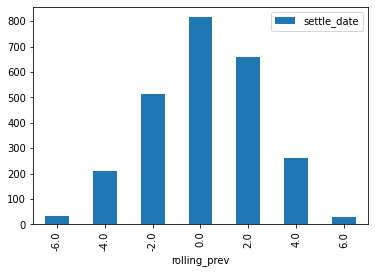

In [891]:
df_cl4 = strat_updown(df_cl3,6,6)
df_cl4[['rolling_prev','settle_date']].groupby('rolling_prev').count().plot.bar()

In [27]:
strat_updown(df_cl3,2,5)

,level_0,level_1,symbol,settle_date,close,expiry,settle_dt,days_to_expiry,commod,prev_chg,next_chg,prev_updown,next_updown,rolling_prev,rolling_next
0,0,1,CLV10,20100901,73.91,2010-09-22,2010-09-01,21,CL,NaN,1.11,-1,1,NaN,1.0
1,1,71,CLV10,20100902,75.02,2010-09-22,2010-09-02,20,CL,1.11,-0.42,1,-1,0.0,1.0
2,2,141,CLV10,20100903,74.60,2010-09-22,2010-09-03,19,CL,-0.42,-0.51,-1,-1,0.0,1.0
3,3,211,CLV10,20100907,74.09,2010-09-22,2010-09-07,15,CL,-0.51,0.16,-1,1,-2.0,1.0
4,4,281,CLV10,20100909,74.25,2010-09-22,2010-09-09,13,CL,0.16,2.20,1,1,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2518,2518,235655,CLV20,20200901,42.76,2020-09-22,2020-09-01,21,CL,0.15,-1.25,1,-1,0.0,-5.0
2519,2519,235795,CLV20,20200902,41.51,2020-09-22,2020-09-02,20,CL,-1.25,-0.14,-1,-1,0.0,NaN
2520,2520,235935,CLV20,20200903,41.37,2020-09-22,2020-09-03,19,CL,-0.14,-1.60,-1,-1,-2.0,NaN
2521,2521,236075,CLV20,20200904,39.77,2020-09-22,2020-09-04,18,CL,-1.60,-3.01,-1,-1,-2.0,NaN


In [28]:
(1300-1223)/(1300+1223)

0.030519223147047168

              settle_date
rolling_prev             
-1.0                 1223
 1.0                 1300


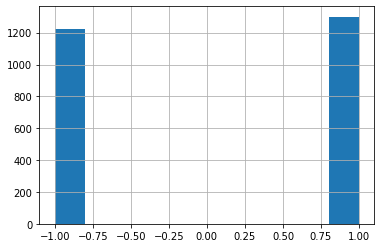

In [29]:
df_cl4 = strat_updown(df_cl3,1,5)
print(df_cl4[['settle_date','rolling_prev']].groupby('rolling_prev').count())

df_cl4.rolling_prev.hist()


### ES contract

In [1022]:
def get_commod_full(commod):
    '''
    Get commodity futures timeseries from postgres db and 
      merge that data with expirations from cme_expirations.py
    '''
    price_sql = f"""
    select symbol, settle_date, open, high, low, close from {futtab} f 
    where substring(f.symbol,1,2)='{commod}'
    """
    df = pga.get_sql(price_sql)
    symbols = df.symbol.unique()
    expiries = [cmeexp.get_expiry(s,is_option=False) for s in symbols]
    df_expiry = pd.DataFrame({'symbol':symbols,'expiry':expiries})
    df = df.merge(df_expiry,on='symbol',how='inner')
    return df

def get_commod(commod):
    '''
    Get commodity futures timeseries from postgres db and 
      merge that data with expirations from cme_expirations.py
    '''
    df_full = get_commod_full(commod)
    return df_full[['symbol', 'settle_date','close']]
    price_sql = f"""
    select symbol, settle_date, close from {futtab} f 
    where substring(f.symbol,1,2)='{commod}'
    """
    df = pga.get_sql(price_sql)
    symbols = df.symbol.unique()
    expiries = [cmeexp.get_expiry(s,is_option=False) for s in symbols]
    df_expiry = pd.DataFrame({'symbol':symbols,'expiry':expiries})
    df = df.merge(df_expiry,on='symbol',how='inner')
    return df

def keep_front_month(df):
    df2 = df.copy()
    df2['settle_dt'] = df2.settle_date.apply(yyyymmdd_to_dt)
    df2['days_to_expiry'] = (df2.expiry - df2.settle_dt).dt.days
    df2['commod'] = df2.symbol.str.slice(0,-3)
    df3 = df2.groupby(
        ['settle_date','commod'],as_index=False).apply(
        lambda df:df[df.days_to_expiry==df.days_to_expiry.min()]
    )
    return df3

In [626]:
df_es_full = get_commod_full('ES')
df_es_full99 = df_es_full[df_es_full.symbol=='ESZ99']
df_es_full99['open_low'] = df_es_full99.open - df_es_full99.low
df_es_full99['dow'] = df_es_full99.settle_date.apply(lambda v:yyyymmdd_dayofweek(v))


In [629]:
df_es_full99.columns.values

array(['symbol', 'settle_date', 'open', 'high', 'low', 'close', 'expiry',
       'open_low', 'dow'], dtype=object)

In [624]:
len(df_es_full99[df_es_full99.open_low<5]),len(df_es_full99)

(1024, 2520)

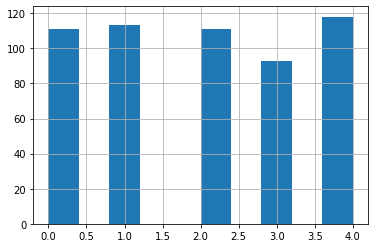

In [628]:
yyyymmdd=20140901
df_es_full99_up_fast = df_es_full99[df_es_full99.open_low<5]
df_es_full99_up_fast[df_es_full99_up_fast.settle_date>=yyyymmdd].dow.hist()
df_es_full99[df_es_full99.prev_u]

In [31]:
df_es = get_commod('ES')

In [32]:
df_es.head()

,symbol,settle_date,close,expiry
0,ESZ99,20100901,1080.29,2099-12-18
1,ESZ99,20100902,1090.10,2099-12-18
2,ESZ99,20100903,1104.51,2099-12-18
3,ESZ99,20100907,1091.84,2099-12-18
4,ESZ99,20100909,1104.18,2099-12-18


In [33]:
df_es2 = keep_front_month(df_es)

In [34]:
df_es2.head(20)

,,symbol,settle_date,close,expiry,settle_dt,days_to_expiry,commod
0,2520,ESU10,20100901,1081.75,2010-09-17,2010-09-01,16,ES
1,2521,ESU10,20100902,1089.50,2010-09-17,2010-09-02,15,ES
2,2522,ESU10,20100903,1103.50,2010-09-17,2010-09-03,14,ES
3,2523,ESU10,20100907,1091.25,2010-09-17,2010-09-07,10,ES
4,2524,ESU10,20100909,1102.50,2010-09-17,2010-09-09,8,ES
5,2525,ESU10,20100910,1109.75,2010-09-17,2010-09-10,7,ES
6,2526,ESU10,20100913,1121.25,2010-09-17,2010-09-13,4,ES
7,2527,ESU10,20100914,1120.75,2010-09-17,2010-09-14,3,ES
8,2528,ESU10,20100915,1125.75,2010-09-17,2010-09-15,2,ES
9,2529,ESU10,20100916,1127.75,2010-09-17,2010-09-16,1,ES


In [35]:
df_es99 = df_es[df_es.symbol=='ESZ99']

In [557]:
?strat_updown

             settle_date
prev_updown             
-1                  1132
 1                  1388
0.5507936507936508


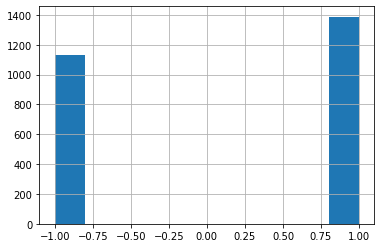

In [877]:
df_es_strat  = strat_updown(df_es99,6,5,up_factor=1)
print(df_es_strat[['settle_date','prev_updown']].groupby('prev_updown').count())
print(df_es_strat[df_es_strat.prev_updown>0].prev_updown.count()/len(df_es_strat))
df_es_strat.prev_updown.hist()

In [879]:
.55*4.5 - .45*5.5

0.0

In [878]:
1388/(1388+1132)

0.5507936507936508

117.20000000000002


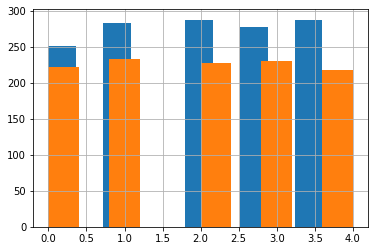

In [632]:
df_es_strat  = strat_updown(df_es99,6,5,up_factor=.9)
df_es_strat['dow'] = df_es_strat.settle_date.apply(lambda v:yyyymmdd_dayofweek(v))
print(df_es_strat.prev_updown.sum())
(df_es_strat[df_es_strat.prev_updown>0].dow*.9).hist()
df_es_strat[df_es_strat.prev_updown<0].dow.hist()

In [634]:
df_es_strat['dow'] = df_es_strat.settle_date.apply(lambda v:yyyymmdd_dayofweek(v))
df_es_strat_by_dow = df_es_strat[['dow','prev_updown']].groupby('dow',as_index=False).sum()
df_es_strat_by_dow


,dow,prev_updown
0,0,3.9
1,1,22.6
2,2,30.3
3,3,19.2
4,4,41.2


In [895]:
df_es_strat = strat_updown(df_es99,6,5,threshold=.0014)
df_es_strat_2_4 = strat_updown(df_es_strat[df_es_strat.dow.isin([2,4])],6,5,threshold=.0014)
df_es_strat90 = strat_updown(df_es99,6,5,up_factor=.9)
df_es_strat90_2_4 = df_es_strat90[df_es_strat90.dow.isin([2,4])]
df_es_strat95 = strat_updown(df_es99,6,5,up_factor=.95)
df_es_strat95_2_4 = df_es_strat95[df_es_strat95.dow.isin([2,4])]

print(f'df_es_strat: {df_es_strat.prev_updown.sum()/len(df_es_strat)}')
print(f'df_es_strat_2_4: {df_es_strat_2_4.prev_updown.sum()/len(df_es_strat_2_4)}')
print(f'df_es_strat90: {df_es_strat90.prev_updown.sum()/len(df_es_strat90)}')
print(f'df_es_strat90_2_4: {df_es_strat90_2_4.prev_updown.sum()/len(df_es_strat90_2_4)}')
print(f'df_es_strat95: {df_es_strat95.prev_updown.sum()/len(df_es_strat95)}')
print(f'df_es_strat95_2_4: {df_es_strat95_2_4.prev_updown.sum()/len(df_es_strat95_2_4)}')



df_es_strat: -0.09841269841269841
df_es_strat_2_4: 0.04407443682664055
df_es_strat90: 0.0015873015873015528
df_es_strat90_2_4: 0.026346718903036206
df_es_strat95: 0.051587301587301584
df_es_strat95_2_4: 0.07634671890303622


In [563]:
r=100
vals = df_es_strat.prev_updown.rolling(r).sum().values
prev_updowns = df_es_strat.prev_updown.values
next_updowns = df_es_strat.next_updown.values
dates = df_es_strat.settle_date
df5 = pd.DataFrame(
    {
        'date':dates[r:],
        'val':vals[r:],
        'prev_updown':prev_updowns[r:],
        'next_updown':prev_updowns[r:],
        'close':df_es_strat.close.values[r:],
    }
)
iplot(
    plotly_plot(
        df5[['date','val','close']],
        x_column='date',yaxis2_cols=['val'],
        y_left_label='Close',y_right_label='updown'
    )
)

In [564]:
result=0
for i in range(len(df5)):
    r = df5.iloc[i]
    if r.val>=-11111:
        result += r.next_updown
result/len(df5[(df5.val>10)])

0.1392712550607291

In [39]:
df6 = strat_updown(df_es99,100,1)
df6.head()

,index,symbol,settle_date,close,expiry,prev_chg,next_chg,prev_updown,next_updown,rolling_prev,rolling_next
0,0,ESZ99,20100901,1080.29,2099-12-18,NaN,9.81,-1,1,NaN,1.0
1,1,ESZ99,20100902,1090.10,2099-12-18,9.81,14.41,1,1,NaN,1.0
2,2,ESZ99,20100903,1104.51,2099-12-18,14.41,-12.67,1,-1,NaN,-1.0
3,3,ESZ99,20100907,1091.84,2099-12-18,-12.67,12.34,-1,1,NaN,1.0
4,4,ESZ99,20100909,1104.18,2099-12-18,12.34,5.37,1,1,NaN,1.0


### Find worst drawdowns

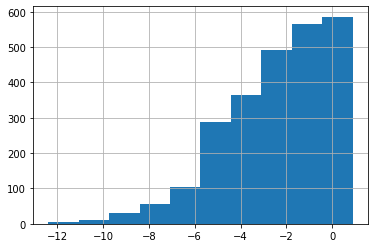

In [565]:
df6 = strat_updown(df_es99,100,1,up_factor=.9)
# df6 = df6[(df6.settle_date>20200201) & (df6.settle_date<20200601)]
def testapply(df):
    len(df)
df6.prev_updown.rolling(20).agg(lambda v:np.cumsum(v).min()).hist()

### Show strategy returns when you only trade when the rolling_prev value is above various levels

In [566]:
for thresh in range(-20,21,2):
    df7=df6[df6.rolling_prev>=thresh]
    print(thresh,
        df7.next_updown.sum(),
        df7.next_updown.sum()/len(df7),
        len(df7)
    )

-20 104.10000000000002 0.04299876084262702 2421
-18 104.10000000000002 0.04299876084262702 2421
-16 101.40000000000002 0.04193548387096775 2418
-14 99.20000000000002 0.041247401247401255 2405
-12 93.20000000000002 0.03927517909818796 2373
-10 75.69999999999999 0.033114610673665786 2286
-8 77.60000000000002 0.036363636363636376 2134
-6 82.50000000000003 0.041291291291291304 1998
-4 72.20000000000003 0.03800000000000002 1900
-2 87.60000000000002 0.04968803176403858 1763
0 81.10000000000002 0.04984634296250769 1627
2 53.70000000000002 0.0369580178940124 1453
4 59.300000000000004 0.04759229534510434 1246
6 53.10000000000001 0.050716332378223504 1047
8 42.100000000000016 0.047463359639233385 887
10 33.2 0.04474393530997305 742
12 37.7 0.06140065146579805 614
14 29.500000000000007 0.06223628691983124 474
16 -6.999999999999998 -0.0324074074074074 216
18 -12.599999999999998 -0.10588235294117646 119
20 -4.1 -0.06507936507936507 63


In [567]:
def plot_strat(df_strat_output):
    dfs = df_strat_output[['settle_date','close','prev_updown']]
    dfs.prev_updown = dfs.prev_updown.cumsum()
    fig = plotly_plot(
            dfs,
            x_column='settle_date',yaxis2_cols=['close'],
            y_left_label='Binary Bet of One Dollar',y_right_label='ES Closing Price',
            plot_title='ES Continuation Close vs Binary  of One Dollar on ES'
        )
    return fig

#### strategy: buy ES  every day

In [670]:
df_es = get_commod_full('ES')
df_es2 = keep_front_month(df_es)
df_es99 = df_es[df_es.symbol=='ESZ99']
first_settle = 20100101
amount_to_discount_gains = 0
df_es_strat  = strat_updown(df_es99[df_es99.settle_date>=first_settle],20,5,up_factor=.95-amount_to_discount_gains)


In [674]:
df_es_strat2 = df_es_strat[['settle_date','close','prev_updown','dow']]
df_es_strat2 = df_es_strat2[df_es_strat2.dow.isin([1,2,3,4])]
f = plot_strat(df_es_strat2)
iplot(f)

0.025

In [45]:
f.write_html('temp_folder/updown_strat_graph.html')

In [46]:
df_es_strat2.to_csv('temp_folder/df_es_strat2.csv',index=False)

### How did the ES Contract do just from February on?
The Chart below lxbjdsljsalfjas;lfjaslfj

In [47]:
df_es_strat3 = df_es_strat2[df_es_strat2.settle_date>=20200215]
iplot(plot_strat(df_es_strat3))

### Read CME settlement ftp files

#### Create df_cme from url below

In [838]:
type([1,3,4])==list

True

In [841]:
def filter_df(df,conditions):
    c = conditions
    if type(conditions)==list:
        c = np.array(c)
    if type(c)not in [np.array,np.ndarray]:
        raise ValueError(f"invalid type for argument conditions: {type(conditions)}")
    c = [all(a) for a in c.T]
    return df[c]


In [537]:
import requests
import io
import zipfile
import urllib


def download_extract_zip(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
#     response = requests.get(url)
    mysock = urllib.request.urlopen(url)
    memfile = io.BytesIO(mysock.read())
    with zipfile.ZipFile(memfile, 'r') as thezip:
        d =  {
            name: pd.read_csv(io.BytesIO(thezip.read(name)))
            for name in thezip.namelist()}
        return list(d.values())[0]


In [778]:
settle_yyyy_mm_dd='20201116'
extra_dot = '.' if len(settle_yyyy_mm_dd)>0 else ''
cme_csv_url = f'ftp://ftp.cmegroup.com/settle/cme.settle{extra_dot}{settle_yyyy_mm_dd}.s.csv'
# df_cme = pd.read_csv(cme_csv_url)
df_cme = download_extract_zip(cme_csv_url+'.zip')

In [779]:
df_cme.columns.values

array(['BizDt', 'Sym', 'ID', 'StrkPx', 'SecTyp', 'MMY', 'MatDt',
       'PutCall', 'Exch', 'Desc', 'LastTrdDt', 'BidPrice', 'OpeningPrice',
       'SettlePrice', 'SettleDelta', 'HighLimit', 'LowLimit',
       'DHighPrice', 'DLowPrice', 'HighBid', 'LowBid', 'PrevDayVol',
       'PrevDayOI', 'FixingPrice', 'UndlyExch', 'UndlyID', 'UndlySecTyp',
       'UndlyMMY', 'BankBusDay'], dtype=object)

In [780]:
def process_call_spread(df_cme,filter_date,pc=1):
    futures_conditions  =  np.array([
        df_cme.Sym=='ES',
        df_cme.SecTyp=='FUT'
    ])
    df_cme_es_fut = filter_df(df_cme,futures_conditions)[['MMY','SettlePrice']]
    settle = df_cme_es_fut.iloc[0].SettlePrice
    mmy =  df_cme_es_fut.iloc[0].MMY

    options_conditions = np.array([
        (df_cme.Sym.astype(str).str.contains('E[0-9][A-Z]')).values,
        (df_cme.SecTyp=='OOF').values,
        (df_cme.MatDt.astype(str).str.contains(filter_date)).values,
        (df_cme.StrkPx>=settle-25).values,
        (df_cme.StrkPx<=settle+25).values,
        (df_cme.PutCall==1).values,
    ])
    df_cme_es_calls = strike_prices = filter_df(df_cme,options_conditions)[['Sym','StrkPx','SettlePrice','PutCall']]
    df_cme_es_calls['abs_diff_from_settle'] = (df_cme_es_calls.StrkPx - settle).abs()
    df_cme_es_calls = df_cme_es_calls.sort_values('abs_diff_from_settle').iloc[0:5].sort_values('StrkPx')
    call1 = df_cme_es_calls.iloc[0] # in the money call
    call2 = df_cme_es_calls.iloc[2] # out of the money call
    call_strike_middle = df_cme_es_calls.iloc[1].StrkPx
    call_spread_price = call1.SettlePrice - call2.SettlePrice
    call1_itms = settle - call1.StrkPx
    theo_call_spread_price = call_spread_strike_diff + settle - call_strike_middle
    return {
        'df_fut':df_cme_es_fut,
        'df_calls':df_cme_es_calls,
        'settle':settle,
        'mmy':mmy,
        'call_spread_price':call_spread_price,
        'call1_itms':call1_itms
    }



In [781]:
results = process_call_spread(df_cme,'2020-11-18')


In [782]:
results['mmy'],results['settle'],results['call_spread_price'],results['call1_itms']

(202012.0, 3623.0, 5.899999999999999, 8.0)

In [783]:
results['df_calls']

,Sym,StrkPx,SettlePrice,PutCall,abs_diff_from_settle
87844,E3C,3615.0,23.7,1.0,8.0
87846,E3C,3620.0,20.6,1.0,3.0
87848,E3C,3625.0,17.8,1.0,2.0
87850,E3C,3630.0,15.2,1.0,7.0
87852,E3C,3635.0,12.8,1.0,12.0


## END

In [775]:
#!pip install py_vollib
import numpy
from py_vollib import black
flag="c"
for F in range(1000,4000,500):
    for sigma in [round(v,3) for v in np.arange(.1,.3,.05)]:
        
        K=F-5
        t=1/365
        rate=.015
        skew=10/F
        c1 = black.black(flag, F, K, t, rate, sigma+skew)
        c2 = black.black(flag, F, K+10, t, rate, sigma-skew)
        print(f'Futures: {F}  vol: {sigma}  callspread: {c1-c2}')

Futures: 1000  vol: 0.1  callspread: 5.256961555618547
Futures: 1000  vol: 0.15  callspread: 5.327710031144061
Futures: 1000  vol: 0.2  callspread: 5.353660614717189
Futures: 1000  vol: 0.25  callspread: 5.363695660252613
Futures: 1500  vol: 0.1  callspread: 5.331972144507231
Futures: 1500  vol: 0.15  callspread: 5.36704216089039
Futures: 1500  vol: 0.2  callspread: 5.376890954137092
Futures: 1500  vol: 0.25  callspread: 5.37879202503154
Futures: 2000  vol: 0.1  callspread: 5.362978396170131
Futures: 2000  vol: 0.15  callspread: 5.381855457677941
Futures: 2000  vol: 0.2  callspread: 5.385362577171727
Futures: 2000  vol: 0.25  callspread: 5.384216269860559
Futures: 2500  vol: 0.1  callspread: 5.378260341460183
Futures: 2500  vol: 0.15  callspread: 5.388904679255704
Futures: 2500  vol: 0.2  callspread: 5.389345208916264
Futures: 2500  vol: 0.25  callspread: 5.386752011718212
Futures: 3000  vol: 0.1  callspread: 5.3868192256444
Futures: 3000  vol: 0.15  callspread: 5.392785989967667
Futur

In [784]:
settle_yyyy_mm_dd='20201113'
extra_dot = '.' if len(settle_yyyy_mm_dd)>0 else ''
nym_csv_url = f'ftp://ftp.cmegroup.com/settle/nymex.settle{extra_dot}{settle_yyyy_mm_dd}.s.csv'
df_nym = download_extract_zip(nym_csv_url+'.zip')

In [809]:
vv = [v[0]+"_"+str(v[1]) for v in df_nym[df_nym.Sym.str.startswith('LO')][['Sym','MMY']].values]
np.sort(np.unique(vv))

array(['LO1_202012', 'LO2_202011', 'LO3_202011', 'LO4_202011',
       'LO_202012', 'LO_202101', 'LO_202102', 'LO_202103', 'LO_202104',
       'LO_202105', 'LO_202106', 'LO_202107', 'LO_202108', 'LO_202109',
       'LO_202110', 'LO_202111', 'LO_202112', 'LO_202201', 'LO_202202',
       'LO_202203', 'LO_202206', 'LO_202207', 'LO_202208', 'LO_202209',
       'LO_202210', 'LO_202212', 'LO_202306', 'LO_202312'], dtype='<U10')

In [803]:
df_nym[df_nym.Sym.str.startswith('LO')].Sym.unique()

array(['LO', 'LO1', 'LO2', 'LO3', 'LO4'], dtype=object)

In [832]:
settle_yyyy_mm_dd='20201116'
extra_dot = '.' if len(settle_yyyy_mm_dd)>0 else ''
comex_csv_url = f'ftp://ftp.cmegroup.com/settle/comex.settle{extra_dot}{settle_yyyy_mm_dd}.s.csv'
df_comex = download_extract_zip(comex_csv_url+'.zip')

In [817]:
np.unique([v[0]+"_"+str(v[1]) for v in df_comex[df_comex.Sym.str.startswith('OG')][['Sym','MMY']].values])

array(['OG1_202012', 'OG2_202011', 'OG3_202011', 'OG4_202011',
       'OG_202012', 'OG_202101', 'OG_202102', 'OG_202103', 'OG_202104',
       'OG_202105', 'OG_202106', 'OG_202107', 'OG_202108', 'OG_202109',
       'OG_202110', 'OG_202111', 'OG_202112', 'OG_202201', 'OG_202202',
       'OG_202203', 'OG_202204', 'OG_202205', 'OG_202206', 'OG_202207',
       'OG_202212', 'OG_202306', 'OG_202312', 'OG_202406', 'OG_202412',
       'OG_202506', 'OG_202512', 'OG_202606'], dtype='<U10')

In [842]:

comex_filters = [
    df_comex.MatDt.str.contains('2020-11'),
    df_comex.Sym.str.startswith('OG')
]

np.sort(filter_df(df_comex,comex_filters).MatDt.unique())

array(['2020-11-20', '2020-11-24', '2020-11-27'], dtype=object)

In [845]:
df_es_db = pga.get_sql(f"select * from {futtab} where substring(symbol,1,2)='ES'")

In [971]:
df_es_db.to_csv('./temp_folder/df_es_db.csv',index=False)

In [847]:
df_es_db.head()

,symbol,settle_date,contract_num,open,high,low,close,adj_close,volume,open_interest
0,ESZ99,20100901,6,1049.72,1081.3,1049.72,1080.29,1080.29,0,0
1,ESU10,20100901,1,1051.75,1082.5,1050.75,1081.75,1081.75,2516451,2964455
2,ESZ10,20100901,2,1047.00,1077.5,1045.75,1076.75,1076.75,19173,77886
3,ESH11,20100901,3,1046.50,1071.5,1046.50,1071.50,1071.50,22,266
4,ESM11,20100901,4,0.00,1067.0,1067.00,1067.00,1067.00,0,38


In [852]:
import cme_expirations as cmexp
df_es_db['expiry'] = df_es_db.symbol.apply(lambda v:cmeexp.get_ES_options_expiry(v))

In [857]:
df_es_db['exp_yyyymmdd'] = [dt_to_yyyymmdd(v) for v in df_es_db.expiry]
df_es_db['dte'] = df_es_db.apply(lambda r: cmeexp.get_dte(r.settle_date,r.exp_yyyymmdd),axis=1)


In [859]:
def get_contract_numbers(df_single_day,dte_col='dte'):
    df_single_day_sorted = df_single_day.sort_values(dte_col)
    df_single_day_sorted.index = list(range(len(df_single_day_sorted)))
    df_single_day_sorted['contract_num'] = df_single_day_sorted.index+1
    return df_single_day_sorted
    
df_es_db[['settle_date','symbol','dte']].groupby('settle_date',as_index=False).apply(get_contract_numbers).tail(60)

settle_date symbol    dte  contract_num
2514 0     20200825  ESU20     24             1
     1     20200825  ESZ20    115             2
     2     20200825  ESH21    206             3
     3     20200825  ESM21    297             4
     4     20200825  ESU21    388             5
     5     20200825  ESZ99  28969             6
2515 0     20200826  ESU20     23             1
     1     20200826  ESZ20    114             2
     2     20200826  ESH21    205             3
     3     20200826  ESM21    296             4
     4     20200826  ESU21    387             5
     5     20200826  ESZ99  28968             6
2516 0     20200827  ESU20     22             1
     1     20200827  ESZ20    113             2
     2     20200827  ESH21    204             3
     3     20200827  ESM21    295             4
     4     20200827  ESU21    386             5
     5     20200827  ESZ99  28967             6
2517 0     20200828  ESU20     21             1
     1     20200828  ESZ20    112             2
     2     20200828  ESH21    203             3
     3     20200828  ESM21    294             4
     4     20200828  ESU21    385             5
     5     20200828  ESZ99  28966             6
2518 0     20200831  ESU20     18             1
     1     20200831  ESZ20    109             2
     2     20200831  ESH21    200             3
     3     20200831  ESM21    291             4
     4     20200831  ESU21    382             5
     5     20200831  ESZ99  28963             6
2519 0     20200901  ESU20     17             1
     1     20200901  ESZ20    108             2
     2     20200901  ESH21    199             3
     3     20200901  ESM21    290             4
     4     20200901  ESU21    381             5
     5     20200901  ESZ99  28962             6
2520 0     20200902  ESU20     16             1
     1     20200902  ESZ20    107             2
     2     20200902  ESH21    198             3
     3     20200902  ESM21    289             4
     4     20200902  ESU21    380             5
     5     20200902  ESZ99  28961             6
2521 0     20200903  ESU20     15             1
     1     20200903  ESZ20    106             2
     2     20200903  ESH21    197             3
     3     20200903  ESM21    288             4
     4     20200903  ESU21    379             5
     5     20200903  ESZ99  28960             6
2522 0     20200904  ESU20     14             1
     1     20200904  ESZ20    105             2
     2     20200904  ESH21    196             3
     3     20200904  ESM21    287             4
     4     20200904  ESU21    378             5
     5     20200904  ESZ99  28959             6
2523 0     20200908  ESU20     10             1
     1     20200908  ESZ20    101             2
     2     20200908  ESH21    192             3
     3     20200908  ESM21    283             4
     4     20200908  ESU21    374             5
     5     20200908  ESZ99  28955             6

In [929]:
df_es_db['sym2'] = df_es_db.symbol.str.slice(0,2) + df_es_db.symbol.str.slice(-2) + df_es_db.symbol.str.slice(-3,-2)
df_es_db2 = df_es_db.sort_values(['settle_date','sym2']).groupby('settle_date',as_index=False).apply(get_contract_numbers)
df_es_db_front = df_es_db2[df_es_db2.contract_num==0]


In [933]:
df_es_db_front2 = df_es_db_front.copy()
df_es_db_front2['prev_symbol'] = df_es_db_front2.symbol.shift()
df_es_db_front2['same_contract'] = df_es_db_front2.symbol==df_es_db_front2.prev_symbol
df_es_db_front2['pct_chg'] = df_es_db_front2.close.pct_change()*df_es_db_front2.same_contract
df_es_db_front2 = df_es_db_front2[~df_es_db_front2.pct_chg.isna()]
df_es_db_front2



,symbol,settle_date,contract_num,open,high,low,close,adj_close,volume,open_interest,expiry,exp_yyyymmdd,dte,sym2,prev_symbol,same_contract,pct_chg
7,ESU10,20100902,0,1081.50,1090.50,1076.50,1089.50,1089.50,2355074,2901867,2010-09-17,20100917,15,ES10U,ESU10,True,0.007164
13,ESU10,20100903,0,1089.75,1104.50,1086.25,1103.50,1103.50,1601762,2875870,2010-09-17,20100917,14,ES10U,ESU10,True,0.012850
19,ESU10,20100907,0,1103.75,1107.25,1089.75,1091.25,1091.25,2017072,2850566,2010-09-17,20100917,10,ES10U,ESU10,True,-0.011101
25,ESU10,20100909,0,1099.25,1112.00,1096.75,1102.50,1102.50,2001331,2602936,2010-09-17,20100917,8,ES10U,ESU10,True,0.010309
31,ESU10,20100910,0,1103.00,1110.50,1100.50,1109.75,1109.75,1612227,2246071,2010-09-17,20100917,7,ES10U,ESU10,True,0.006576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15217,ESU20,20200901,0,3493.25,3530.00,3484.25,3527.00,3527.00,1439600,2688708,2020-09-18,20200918,17,ES20U,ESU20,True,0.008002
15223,ESU20,20200902,0,3529.00,3587.00,3526.25,3579.25,3579.25,1283622,2696614,2020-09-18,20200918,16,ES20U,ESU20,True,0.014814
15229,ESU20,20200903,0,3578.75,3586.50,3424.50,3461.50,3461.50,1853078,2680985,2020-09-18,20200918,15,ES20U,ESU20,True,-0.032898
15235,ESU20,20200904,0,3454.75,3484.25,3347.75,3417.50,3417.50,2872337,2665365,2020-09-18,20200918,14,ES20U,ESU20,True,-0.012711


In [968]:
thresh = 0.000
call_spread = 2.7
df_es_db_front2_up = df_es_db_front2[df_es_db_front2.pct_chg>thresh]
df_es_db_front2_down = df_es_db_front2[df_es_db_front2.pct_chg<thresh]
profit = len(df_es_db_front2_up)*(5-call_spread) - len(df_es_db_front2_down)*call_spread
up_days = len(df_es_db_front2_up)
down_days = len(df_es_db_front2_down)
all_days = up_days + down_days
{
    'all_days':all_days,
    'up_days':up_days,
    'down_days':down_days,
    'up_days/all_days':up_days/all_days,
    'down_days/all_days':down_days/all_days,
    'profit':profit,
    'per_trade_avg_profit':profit/all_days,
    'mean_pct_change':df_es_db_front2.pct_chg.mean(),
    'mean_uppct_change':df_es_db_front2_up.pct_chg.mean(),
    'mean_downpct_change':df_es_db_front2_down.pct_chg.mean()

}
    

{'all_days': 2449,
 'up_days': 1375,
 'down_days': 1074,
 'up_days/all_days': 0.5614536545528788,
 'down_days/all_days': 0.4385463454471213,
 'profit': 262.69999999999936,
 'per_trade_avg_profit': 0.10726827276439337,
 'mean_pct_change': 0.0006315430617851898,
 'mean_uppct_change': 0.006752222153110523,
 'mean_downpct_change': -0.007161007742684291}

In [948]:
df_es_db_front2.to_csv('./temp_folder/df_es_db_front2.csv',index=False)

In [951]:
#!bash ~/openExcel.sh ./temp_folder/df_es_db_front2.csv

In [984]:
strk_diff = 10
pr = 4.5
a = np.arange(3000,3065,5)
b = a[0]
e = a[-1]
p = e-b
o = [[-pr,strk_diff-pr] for _ in range(len(a))]
o

[[-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5],
 [-4.5, 5.5]]

In [987]:
[
    [p,pr*len(a[:-1])],
    [0,12*5.5+.5]
]



[[60, 54.0], [0, 66.5]]